In [175]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import time
import yaml
import math
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms import ToPILImage, ToTensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import Adam
from torchvision.utils import save_image
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


sys.path.append("models")
import models
from models import losses
from models.liif import LIIF
from models.discriminator import Discriminator
from models.losses import AdversarialLoss

import utils
from utils import make_coord,set_save_path,ssim
import datasets
from test import eval_psnr_ssim, batched_predict

%matplotlib inline

ImportError: cannot import name 'eval_psnr_ssim' from 'test' (d:\Miniconda3\envs\pytorch\lib\test\__init__.py)

In [ ]:
img = Image.open(r'load\div2k\DIV2K_valid_LR_bicubic\X2\0802x2.png')
#img = transforms.Resize((int(img.height/2),int(img.width/2)),Image.BICUBIC)(img)
timg = transforms.ToTensor()(img) #[3,LR_H,LR_W]
edgemap = edge.laplacian_kernel(timg.unsqueeze(0).cuda())
transforms.ToPILImage()(edgemap[0]).save('0802x2edge.jpg')

In [ ]:
#pytorch 求LPIPS
 


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: d:\Miniconda3\envs\pytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [ ]:
import torch
import lpips
import os
import numpy as np

def cal_lpips(hr_img_path,sr_img_path):
    loss_fn = lpips.LPIPS(net='alex').cuda() # Can also set net = 'squeeze' or 'vgg'
    hr_path_list = []
    sr_path_list = []

    for root, _, fnames in sorted(os.walk(hr_img_path, followlinks=True)):
        for fname in fnames:
            path = os.path.join(hr_img_path, fname)
            hr_path_list.append(path)

    for root, _, fnames in sorted(os.walk(sr_img_path, followlinks=True)):
        for fname in fnames:
            path = os.path.join(sr_img_path, fname)
            sr_path_list.append(path)
    dist_ = []
    for i in range(len(hr_path_list)):
        hr_img = lpips.im2tensor(lpips.load_image(hr_path_list[i])).cuda()
        sr_img = lpips.im2tensor(lpips.load_image(sr_path_list[i])).cuda()
        dist = loss_fn.forward(hr_img, sr_img)
        dist_.append(dist.mean().item())

    print('Avarage Distances: %.3f' % (sum(dist_)/len(hr_path_list)))
    return np.mean(dist_)
            

In [ ]:
## Example usage with dummy tensors
hr_path = r'E:\Code\Python\datas\selfWHURS\WHURS19-test\GT'
sr_path = r'E:\Code\Python\liif-self\result\WHURS19_edsrblx4'
vlpips = cal_lpips(hr_path,sr_path)



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: d:\Miniconda3\envs\pytorch\lib\site-packages\lpips\weights\v0.1\alex.pth
Avarage Distances: 0.339


In [ ]:
modelpath = r'weights\edsr-baseline-liif.pth'
lr_path = r'testimg\div2klrx4\0801x4.png'
hr_path = r'load\div2k\DIV2K_valid_HR\0801.png'
sr_path = r'testimg\ouput.jpg'

lr = transforms.ToTensor()(Image.open(lr_path))
hr = transforms.ToTensor()(Image.open(hr_path))
model = models.make(torch.load(modelpath)['model'], load_sd=True).cuda()
lr = ((lr - 0.5) / 0.5).cuda().unsqueeze(0)
with torch.no_grad():
    feat = model.gen_feat(lr)
featimg= transforms.ToPILImage()(feat[0][0])
plt.imshow(featimg)

In [ ]:
class Get_gradient(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_v = [[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]]
        kernel_h = [[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data=kernel_h, requires_grad=False).cuda()
        self.weight_v = nn.Parameter(data=kernel_v, requires_grad=False).cuda()

    def forward(self, x):
        x_list = []
        for i in range(x.shape[1]):
            x_i = x[:, i]
            x_i_v = F.conv2d(x_i.unsqueeze(1), self.weight_v, padding=1)
            x_i_h = F.conv2d(x_i.unsqueeze(1), self.weight_h, padding=1)
            x_i = torch.sqrt(torch.pow(x_i_v, 2) + torch.pow(x_i_h, 2) + 1e-6)
            x_list.append(x_i)
        x = torch.cat(x_list, dim = 1)
        
        return x

In [ ]:
class Get_sobel_gradient(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_v = [[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]]
        kernel_h = [[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data=kernel_h, requires_grad=False).cuda()
        self.weight_v = nn.Parameter(data=kernel_v, requires_grad=False).cuda()

    def forward(self, x):
        x_list = []
        for i in range(x.shape[1]):
            x_i = x[:, i]
            x_i_v = F.conv2d(x_i.unsqueeze(1), self.weight_v, padding=1)
            x_i_h = F.conv2d(x_i.unsqueeze(1), self.weight_h, padding=1)
            x_i = torch.sqrt(torch.pow(x_i_v, 2) + torch.pow(x_i_h, 2) + 1e-6)
            x_list.append(x_i)
        x = torch.cat(x_list, dim = 1)
        
        return x

In [ ]:
class Get_laplacian_gradient(nn.Module):
    def __init__(self):
        super().__init__()
        kernel = [[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]]
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        self.weight = nn.Parameter(data=kernel, requires_grad=False).cuda()

    def forward(self, x):
        x_list = []
        for i in range(x.shape[1]):
            x_i = F.conv2d(x[:, i].unsqueeze(1), self.weight, padding=1)
            x_list.append(x_i)
        x = torch.cat(x_list, dim = 1)
        return x

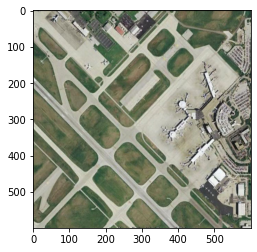

In [ ]:
img = Image.open(r'data\WHU-RS19-train\GT\airport_10.jpg')
imgt = ToTensor()(img).unsqueeze(0).cuda()
plt.imshow(img)

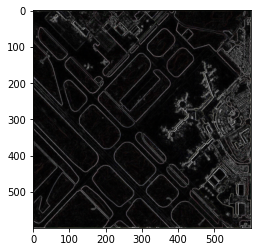

In [ ]:
out = Get_gradient()(imgt)
gimg = ToPILImage()(out.squeeze(0))
plt.imshow(gimg)
plt.imsave("airport_10_hr_gradient_test.png",gimg.convert('L'))

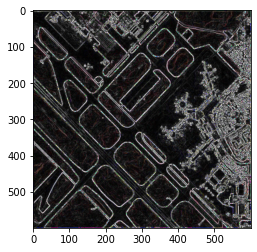

In [ ]:
out = Get_sobel_gradient()(imgt)
plt.imshow(ToPILImage()(out.squeeze(0)))

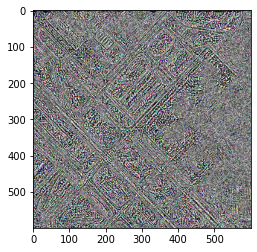

In [ ]:
out = Get_laplacian_gradient()(imgt)
plt.imshow(ToPILImage()(out.squeeze(0)))

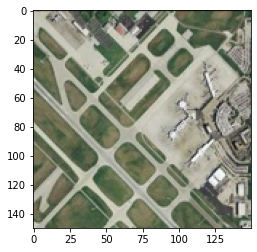

In [ ]:
img = Image.open(r'data\WHU-RS19-train\GT\airport_10.jpg')
imgt = ToTensor()(img).unsqueeze(0).cuda()
plt.imshow(img)

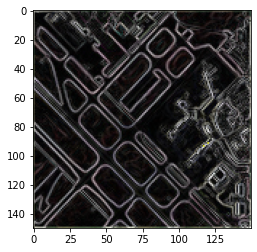

In [ ]:
out = Get_gradient()(imgt)
plt.imshow(ToPILImage()(out.squeeze(0)))

In [196]:
r = torch.randn(1,64,48,48)
r

tensor([[[[ 1.3026,  0.1779, -0.2521,  ...,  0.7038, -0.4820,  1.2730],
          [ 0.3213,  0.7338,  0.7276,  ...,  0.8142, -0.2962, -0.2096],
          [ 1.8766,  0.2343,  0.7370,  ..., -0.9698, -0.9955, -0.3544],
          ...,
          [ 0.1574, -1.2319,  1.1681,  ..., -0.2238, -0.2882, -2.2384],
          [ 0.2135, -0.9861, -0.3651,  ...,  0.2986,  0.4322, -0.3435],
          [ 2.6191, -0.8621, -1.2233,  ..., -1.1662,  0.0716, -0.4790]],

         [[-0.0980, -0.9574, -0.5243,  ..., -0.4420, -0.2677,  0.2823],
          [ 1.0097,  0.7765, -0.2581,  ...,  0.2504,  0.7807,  0.9980],
          [-2.3844,  0.1454,  0.5103,  ...,  0.2278, -1.3055, -0.3915],
          ...,
          [ 1.3464,  1.5329,  0.7928,  ...,  0.6849, -1.2833,  0.7661],
          [ 1.6162, -1.0039,  1.3775,  ...,  1.2074, -0.1902, -0.1577],
          [-0.1596,  0.2868, -0.9808,  ...,  0.3923, -1.0602, -0.3999]],

         [[-1.2128, -1.5963, -0.9883,  ..., -0.0592,  0.0622, -0.3421],
          [-0.1403,  0.5911,  

In [197]:
y = nn.Softmax(-1)(r)

In [198]:
y

tensor([[[[0.0422, 0.0137, 0.0089,  ..., 0.0232, 0.0071, 0.0410],
          [0.0134, 0.0203, 0.0202,  ..., 0.0220, 0.0072, 0.0079],
          [0.0856, 0.0166, 0.0274,  ..., 0.0050, 0.0048, 0.0092],
          ...,
          [0.0125, 0.0031, 0.0342,  ..., 0.0085, 0.0080, 0.0011],
          [0.0149, 0.0045, 0.0084,  ..., 0.0162, 0.0186, 0.0085],
          [0.1674, 0.0052, 0.0036,  ..., 0.0038, 0.0131, 0.0076]],

         [[0.0107, 0.0045, 0.0070,  ..., 0.0076, 0.0091, 0.0157],
          [0.0418, 0.0331, 0.0118,  ..., 0.0196, 0.0332, 0.0413],
          [0.0015, 0.0187, 0.0270,  ..., 0.0203, 0.0044, 0.0109],
          ...,
          [0.0390, 0.0470, 0.0224,  ..., 0.0201, 0.0028, 0.0218],
          [0.0529, 0.0039, 0.0417,  ..., 0.0352, 0.0087, 0.0090],
          [0.0121, 0.0190, 0.0053,  ..., 0.0211, 0.0049, 0.0096]],

         [[0.0062, 0.0042, 0.0077,  ..., 0.0196, 0.0221, 0.0148],
          [0.0089, 0.0185, 0.0173,  ..., 0.0047, 0.0199, 0.0005],
          [0.0072, 0.0020, 0.0089,  ..., 0

In [199]:
y.shape

torch.Size([1, 64, 48, 48])

In [193]:
nn.Softmax(1)(r)

tensor([[[0.0106, 0.0088, 0.0108,  ..., 0.0071, 0.0034, 0.0038],
         [0.0126, 0.0539, 0.0164,  ..., 0.0079, 0.0062, 0.0097],
         [0.0056, 0.0075, 0.0063,  ..., 0.0494, 0.0068, 0.0067],
         ...,
         [0.0150, 0.0311, 0.0063,  ..., 0.0023, 0.0217, 0.0066],
         [0.0035, 0.0256, 0.0061,  ..., 0.0057, 0.0373, 0.0057],
         [0.0470, 0.0300, 0.0106,  ..., 0.0069, 0.0187, 0.0161]]])

In [224]:
class PixelSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.softmax=nn.Softmax(-1)
        self.sigmoid=nn.Sigmoid()
        self.wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))

    def forward(self, x):
        b, c, h, w = x.size()
        #Pixel-only Self-Attention
        wv=self.wv(x) #bs,c//2,h,w
        wq=self.wq(x) #bs,c//2,h,w
        wv=wv.reshape(b,c//2,-1) #bs,c//2,h*w
        wq=wq.reshape(b,c//2,-1) #bs,c//2,h*w
        wq=self.softmax(wq)
        print("wq ", wq.shape)
        print("wv ", wv.shape)
        qv=torch.mul(wq,wv) #bs,c//2,h*w
        qv = qv.reshape(b,c//2,h, w)
        print("qv ", qv.shape)
        weight=self.sigmoid(self.wz(qv)) #bs,C,h,w
        print("weight ", weight.shape)
        out=weight*x
        out=out+x
        return out

In [228]:
i = torch.randn(10,64,150,150)
ppsa = PixelSelfAttention(64)
z = ppsa(i)


wq  torch.Size([10, 32, 22500])
wv  torch.Size([10, 32, 22500])
qv  torch.Size([10, 32, 150, 150])
weight  torch.Size([10, 64, 150, 150])


In [223]:
z

tensor([[[[ 2.0065,  0.2740, -0.3883,  ...,  1.0841, -0.7424,  1.9609],
          [ 0.4949,  1.1304,  1.1207,  ...,  1.2542, -0.4562, -0.3228],
          [ 2.8906,  0.3609,  1.1352,  ..., -1.4938, -1.5334, -0.5459],
          ...,
          [ 0.2424, -1.8976,  1.7993,  ..., -0.3448, -0.4439, -3.4481],
          [ 0.3288, -1.5190, -0.5624,  ...,  0.4599,  0.6658, -0.5291],
          [ 4.0341, -1.3279, -1.8843,  ..., -1.7964,  0.1102, -0.7378]],

         [[-0.1446, -1.4125, -0.7735,  ..., -0.6520, -0.3950,  0.4165],
          [ 1.4896,  1.1456, -0.3808,  ...,  0.3694,  1.1518,  1.4724],
          [-3.5176,  0.2146,  0.7529,  ...,  0.3361, -1.9260, -0.5775],
          ...,
          [ 1.9865,  2.2615,  1.1696,  ...,  1.0106, -1.8934,  1.1303],
          [ 2.3843, -1.4810,  2.0324,  ...,  1.7814, -0.2806, -0.2327],
          [-0.2354,  0.4231, -1.4470,  ...,  0.5788, -1.5640, -0.5899]],

         [[-1.8457, -2.4294, -1.5041,  ..., -0.0901,  0.0946, -0.5207],
          [-0.2135,  0.8995,  

In [218]:
a = [1,2,3]
b = [2,4,6]

In [222]:
torch.mul(torch.tensor(a),torch.tensor(b))

tensor([ 2,  8, 18])